In [1]:
%matplotlib inline
import time
import itertools
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R
from coppeliasim_zmqremoteapi_client import *

np.set_printoptions(precision=3, suppress=True)

SCENE_PATH = '/Users/kuang-yujeng/Downloads/UR.ttt'
WAIT_INTERVAL = 0.1 # 0.1s
TIMEOUT = 3 # 3s
ACCEPT_RERR = 0.1
ACCEPT_TERR = 0.0003
ACCEPT_STOP_VEL = 1e-3

In [2]:
# Step 1: Connect to CoppeliaSim using ZeroMQ Remote API
def connect_to_coppeliasim():
    client = RemoteAPIClient()
    sim = client.require('sim')
    sim.stopSimulation(True)
    sim.loadScene(SCENE_PATH)
    sim.startSimulation()
    return client, sim

# Step 2: Get object handles
def get_handles(sim):
    ur_base = sim.getObject('/UR10')
    ur_ee = sim.getObject('/UR10/connection')
    camera_bgr = sim.getObject('/UR10/kinect/rgb')
    camera_depth = sim.getObject('/UR10/kinect/depth')
    ur_ee_target = sim.getObject('/UR10/connection_manipSphere')
    return ur_base, ur_ee, camera_bgr, camera_depth, ur_ee_target

def get_cv2_bgr(camera_bgr):
    img, [resX, resY] = sim.getVisionSensorImg(camera_bgr)
    img = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)
    return cv2.flip(img, 0)

def set_frame_pose(sim, from_frame, to_frame, T):
    sim.setObjectMatrix(to_frame, from_frame, T[:3].ravel())

def get_frame_pose(sim, from_frame, to_frame):
    T = np.eye(4, dtype=np.float32)
    T[:3,:4] = np.array(sim.getObjectMatrix(to_frame, from_frame)).reshape(3,4)
    return T

def pose_error(T, T_target):
    t_err = np.linalg.norm(T[:3,-1]-T_target[:3,-1])
    r_err = T[:3,:3]@T_target[:3,:3].T
    r_err = np.degrees(np.arccos(np.clip((np.trace(r_err)-1)/2, -1, 1)))
    return r_err, t_err

def wait_robot_move(T_target, get_pose_fn, get_vel_fn):
    t_start = time.time()
    r_err, t_err = np.inf, np.inf
    while True:
        t_elapsed = time.time() - t_start
        if t_elapsed > TIMEOUT:
            return False, r_err, t_err
        time.sleep(WAIT_INTERVAL)
        T = get_pose_fn()
        v_linear, v_angular = get_vel_fn()
        v_linear = np.mean(v_linear)
        v_angular = np.mean(v_angular)
        r_err, t_err = pose_error(T, T_target)
        if r_err < ACCEPT_RERR and t_err < ACCEPT_TERR and v_linear < ACCEPT_STOP_VEL and v_angular < ACCEPT_STOP_VEL:
            return True, r_err, t_err

def set_frame_pose_and_wait(sim, from_frame, ik_frame, ee_frame, T):
    set_frame_pose(sim, from_frame, ik_frame, T)
    return wait_robot_move(T, lambda: get_frame_pose(sim, from_frame, ee_frame), lambda: sim.getObjectVelocity(ee_frame))

In [3]:
client, sim = connect_to_coppeliasim()
ur_base, ur_ee, camera_bgr, camera_depth, ur_ee_target = get_handles(sim)

In [4]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
flags = cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_FIX_PRINCIPAL_POINT + cv2.CALIB_ZERO_TANGENT_DIST + cv2.CALIB_FIX_FOCAL_LENGTH + cv2.CALIB_FIX_K3 + cv2.CALIB_FIX_K4 + cv2.CALIB_FIX_K5 + cv2.CALIB_FIX_K6
# Detect checkerboard corners in the images
checkerboard_size = (10, 7)  # Example size, adjust as needed
unit = 0.025 # in meters
objp = np.zeros((checkerboard_size[0]*checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2) * unit

In [5]:
img = get_cv2_bgr(camera_bgr)
h, w = int(img.shape[0]), int(img.shape[1])

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)

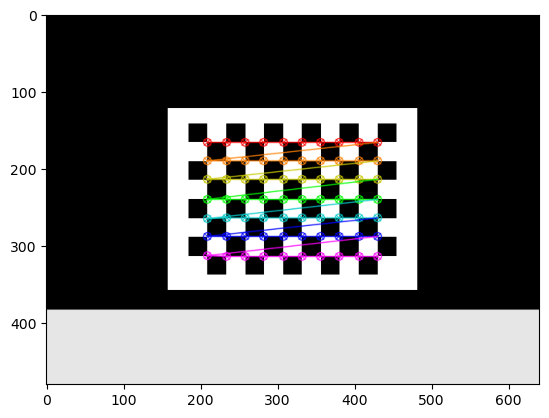

In [7]:
plt.imshow(cv2.drawChessboardCorners(img.copy(), checkerboard_size, corners, True)[...,::-1])
plt.show()

In [8]:
T_original = get_frame_pose(sim, ur_base, ur_ee)
T_original

array([[-0.   , -0.   , -1.   , -0.35 ],
       [ 0.   ,  1.   , -0.   ,  0.172],
       [ 1.   , -0.   , -0.   ,  0.754],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)

In [9]:
tx, ty, tz = 0, 0, -0.1
rx, ry, rz = 15, 0, 0

T = np.array([[1, 0, 0, tx],
              [0, 1, 0, ty],
              [0, 0, 1, tz],
              [0, 0, 0, 1]], dtype=np.float32)
T_rot = np.eye(4, dtype=np.float32)
T_rot[:3,:3] = R.from_euler('zyx', [rz, ry, rx], degrees=True).as_matrix()
T = T@T_rot
T_target = T_original@T
set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_target)

(True, 0.0, 1.4901161e-08)

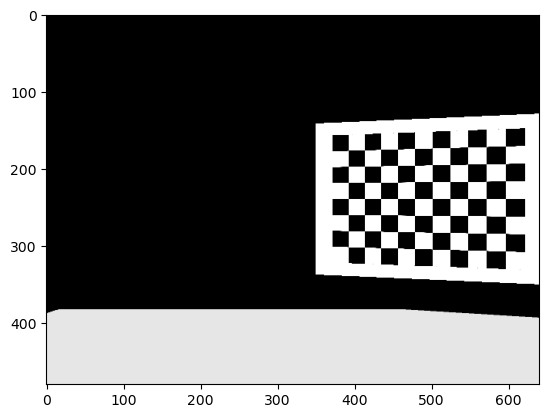

In [10]:
plt.imshow(get_cv2_bgr(camera_bgr)[...,::-1])
plt.show()

In [11]:
set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_original)

(True, 0.0, 3.968887e-06)

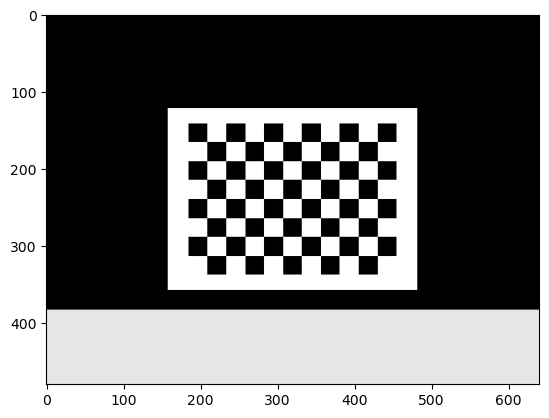

In [12]:
plt.imshow(get_cv2_bgr(camera_bgr)[...,::-1])
plt.show()

In [13]:
x_range = [-0.07, 0, 0.07]
y_range = [-0.05, 0.05]
z_range = [-0.1, 0.2]
alpha_range = [-15, 15]
beta_range = [-7, 7]
gamma_range = [0]
Ts = []
for tz, tx, ty, rx, ry, rz in itertools.product(z_range, x_range, y_range, alpha_range, beta_range, gamma_range):
    T = np.array([[1, 0, 0, tx],
                  [0, 1, 0, ty],
                  [0, 0, 1, tz],
                  [0, 0, 0, 1]], dtype=np.float32)
    T_rot = np.eye(4, dtype=np.float32)
    T_rot[:3,:3] = R.from_euler('zyx', [rz, ry, rx], degrees=True).as_matrix()
    T = T@T_rot
    Ts.append(T)

In [14]:
len(Ts)

48

0.0 1.8495242e-05


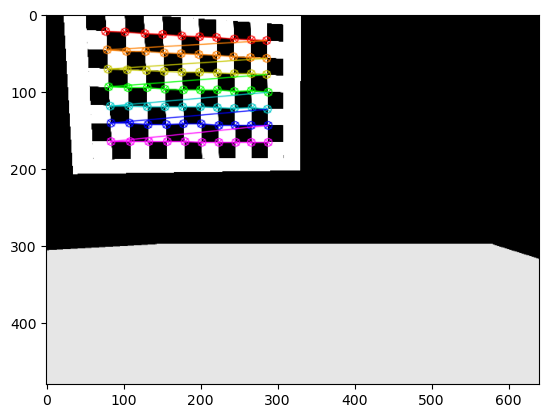

0.0 7.450581e-09


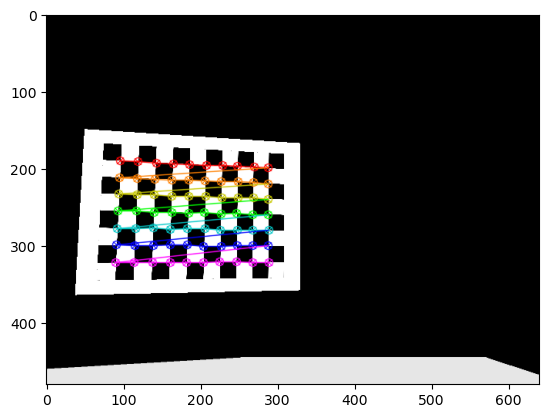

0.0 1.4901161e-08


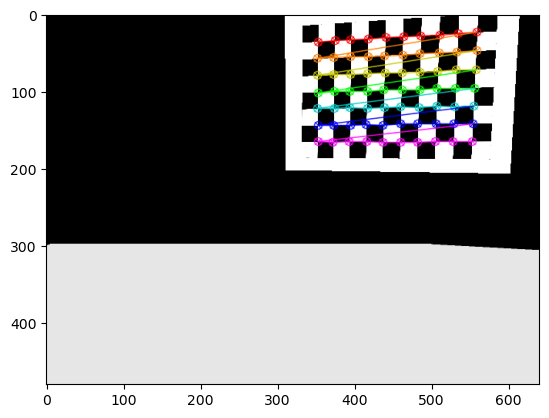

0.0 5.8614432e-06


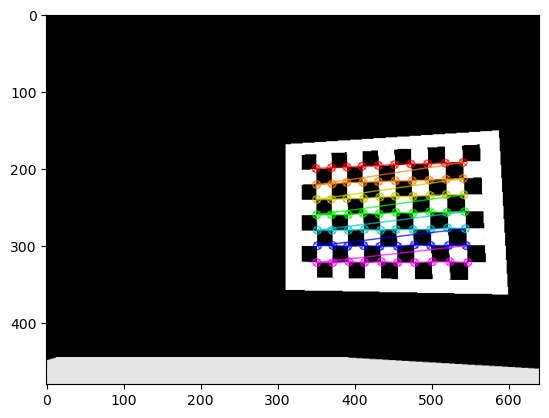

0.0 1.4149043e-06


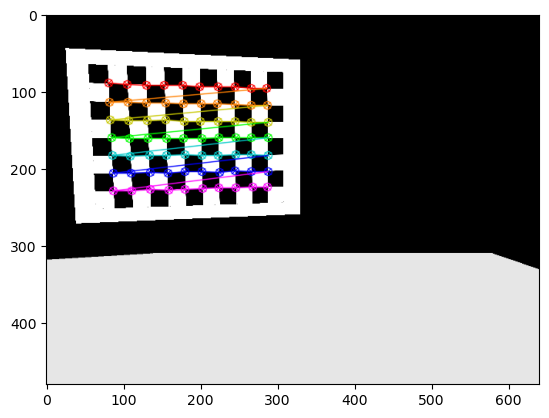

0.0 7.450581e-09


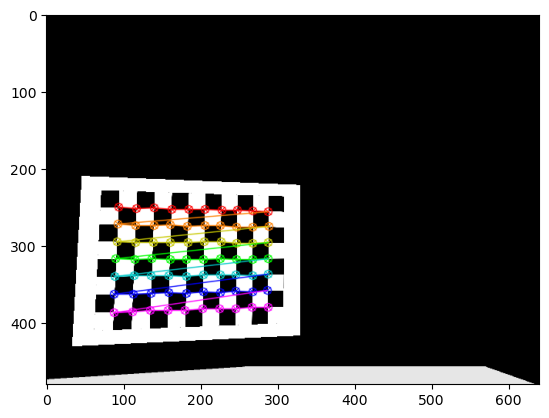

0.0 1.8044561e-06


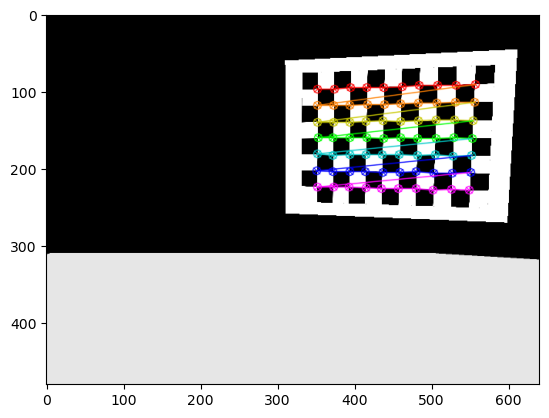

0.0 5.2992855e-06


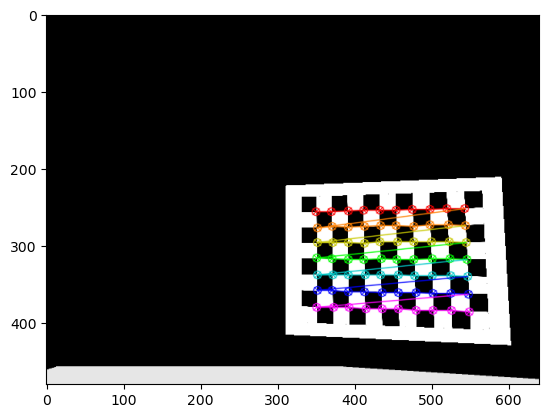

0.0 5.0361734e-07


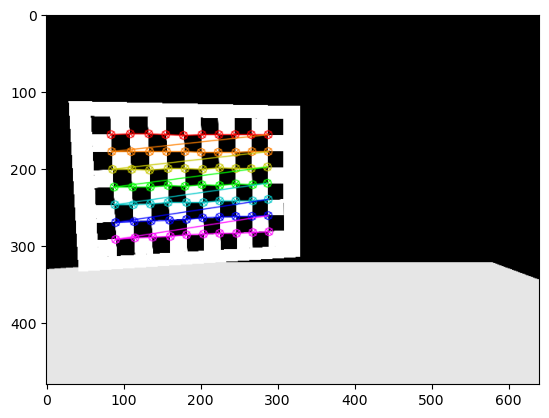

0.0 7.450581e-09


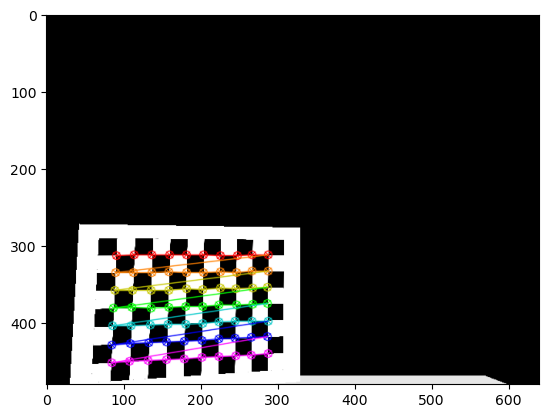

0.0 5.17491e-06


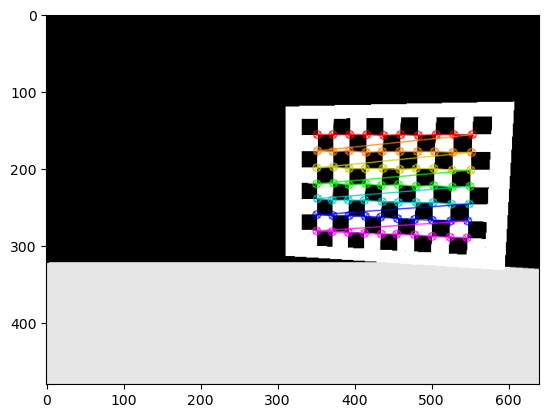

0.0 6.664002e-08


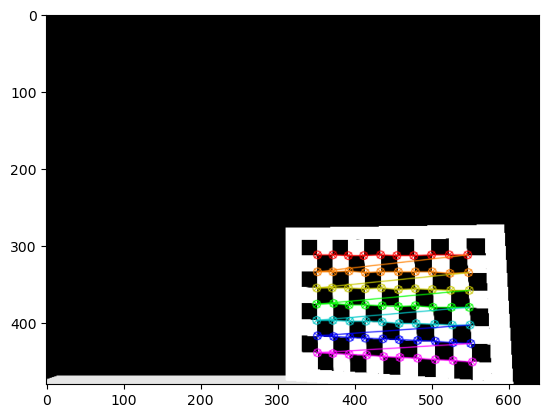

0.0 1.7499984e-06


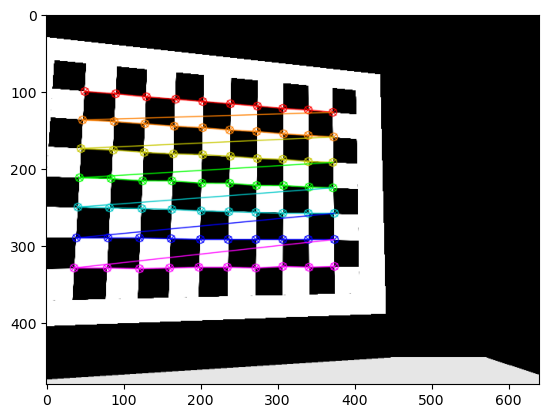

0.0 1.5319234e-06


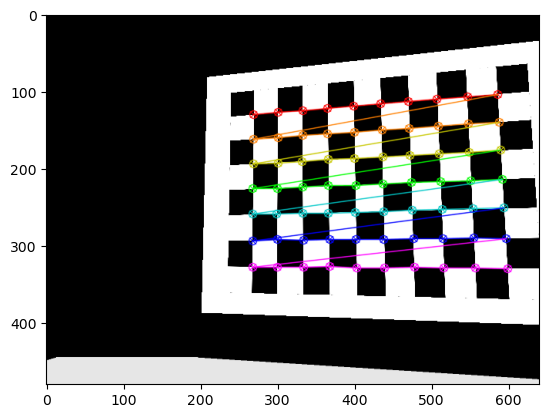

0.027976455118293345 4.913797e-05


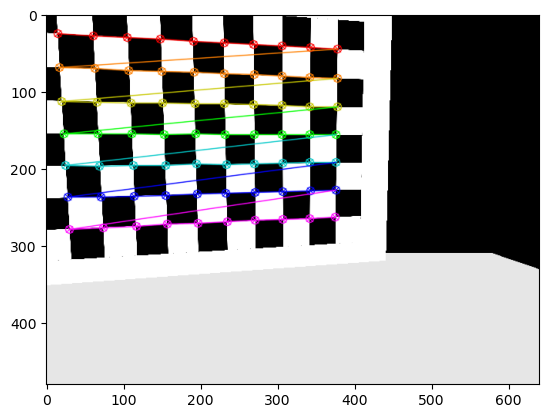

0.0 1.7499984e-06


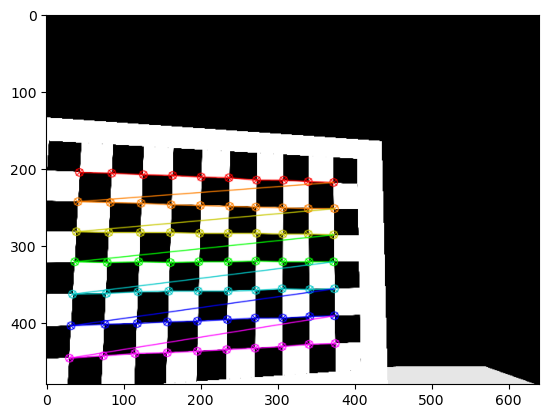

0.0 2.3132823e-07


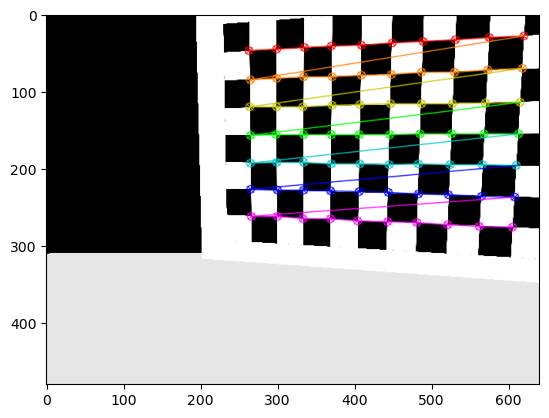

0.0 4.381752e-06


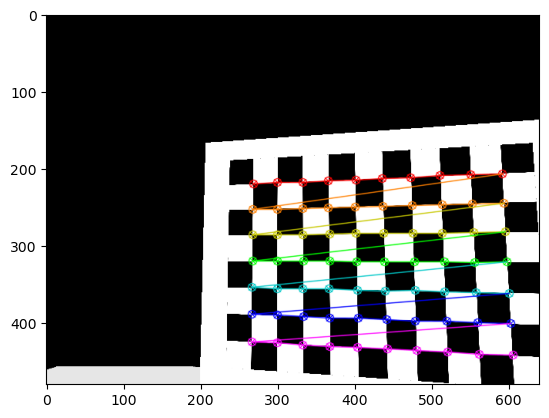

0.09278741380920028 0.00014224587


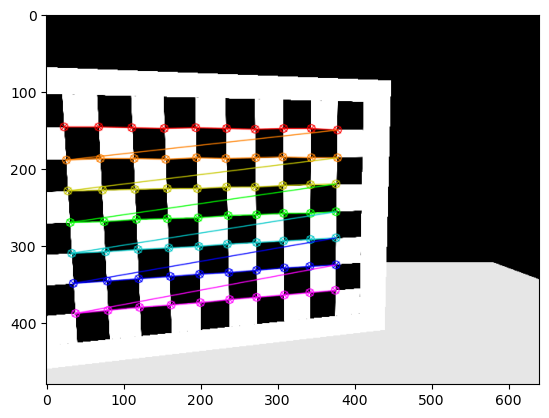

0.0 2.3132823e-07


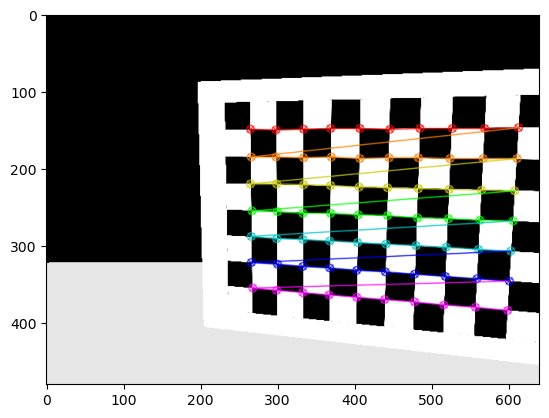

In [15]:
image_points = []
obj_points = []
T_ee_poses = []

imgs = []

for T in Ts:
    T_target = T_original@T
    ret, r_err, t_err = set_frame_pose_and_wait(sim, ur_base, ur_ee_target, ur_ee, T_target)
    if not ret:
        continue
    img = get_cv2_bgr(camera_bgr)
    T_ee_pose = get_frame_pose(sim, ur_base, ur_ee)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)
    if not ret:
        continue
    print(r_err, t_err)
    corners = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    plt.imshow(cv2.drawChessboardCorners(img.copy(), checkerboard_size, corners, True)[...,::-1])
    plt.show()
    
    image_points.append(corners)
    obj_points.append(objp)
    T_ee_poses.append(T_ee_pose)

    imgs.append(img)

In [16]:
len(image_points)

20

In [17]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, image_points, (w, h), None, None, criteria=criteria, flags=flags)

In [18]:
mtx

array([[591.698,   0.   , 319.5  ],
       [  0.   , 591.698, 239.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [19]:
dist

array([[-0.003,  0.014,  0.   ,  0.   ,  0.   ]])

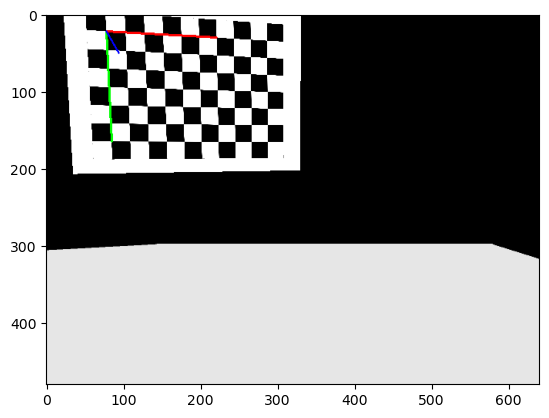

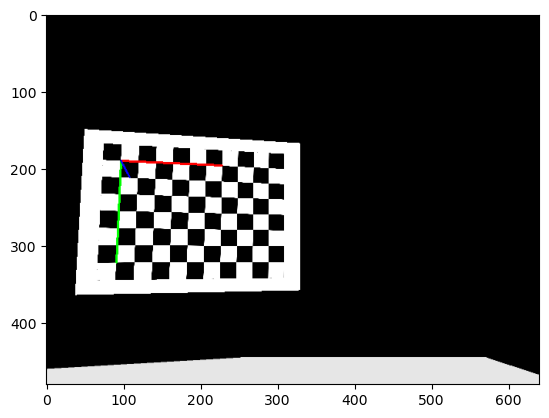

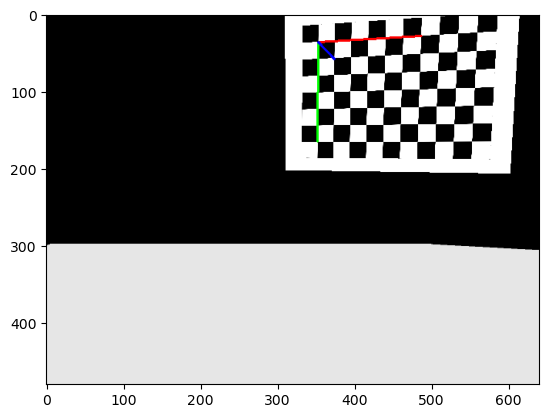

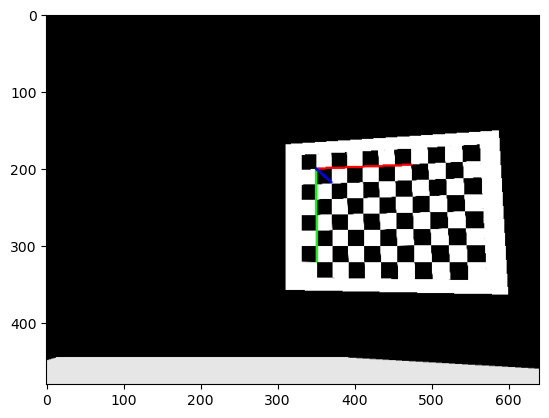

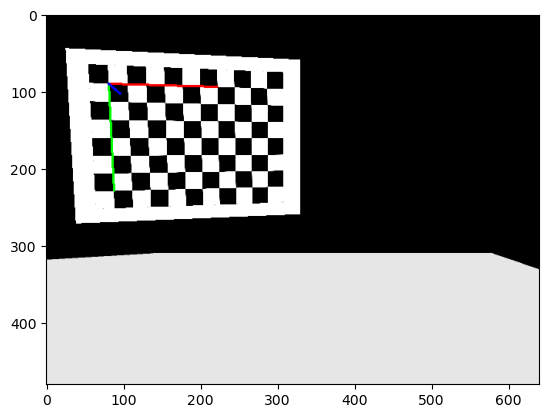

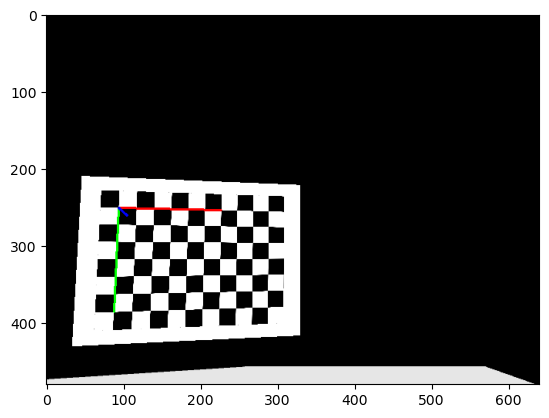

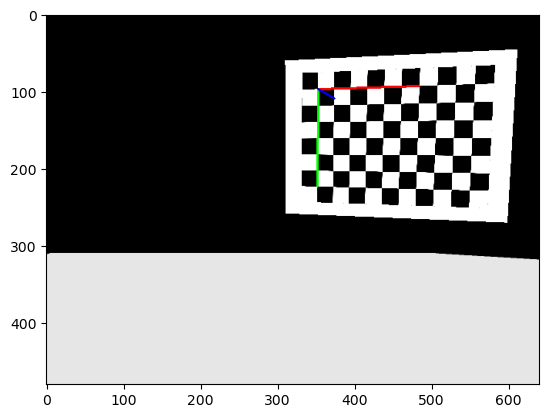

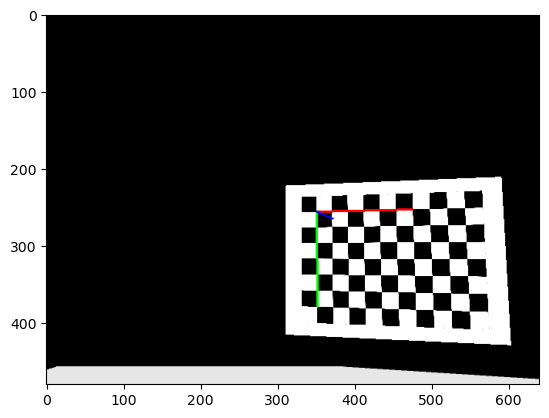

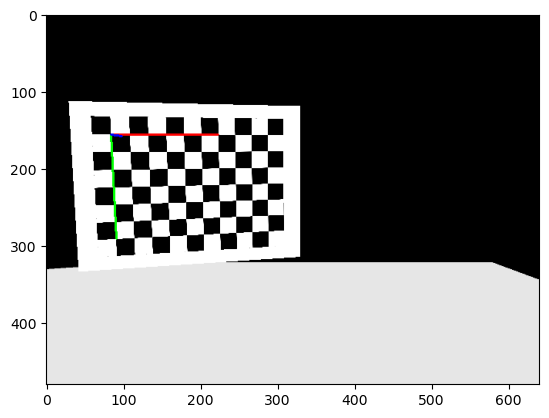

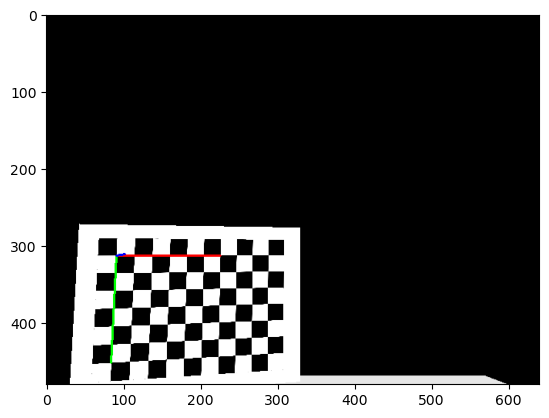

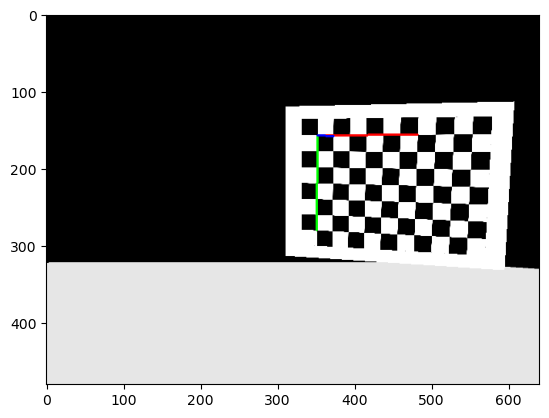

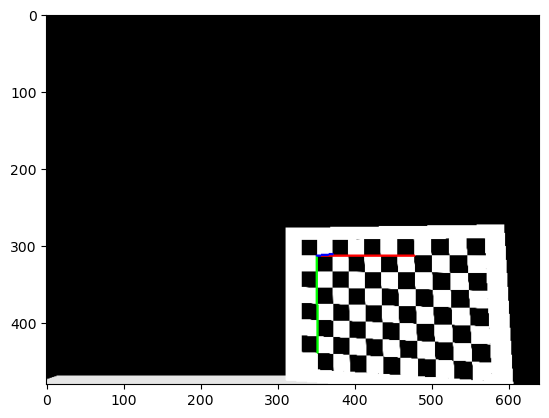

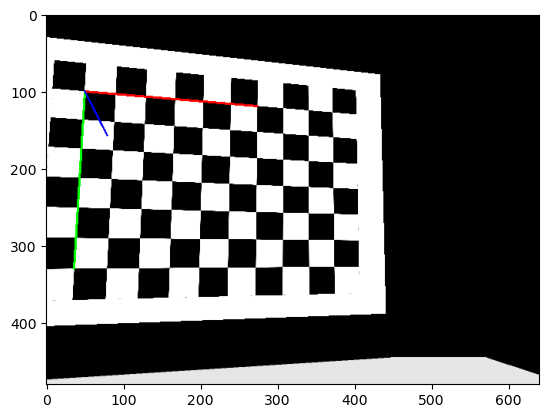

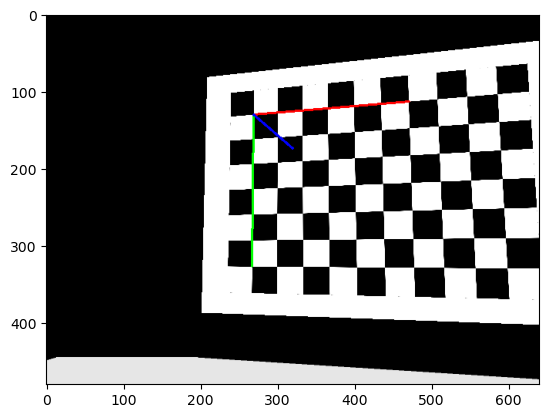

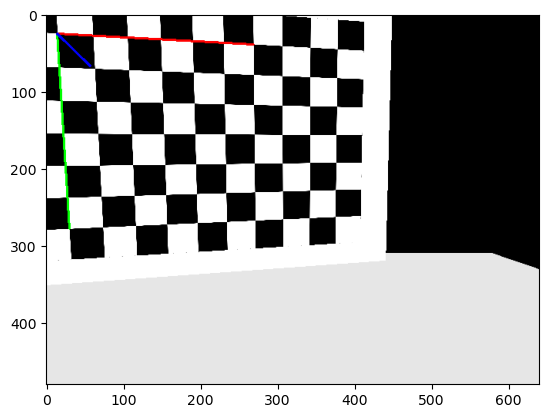

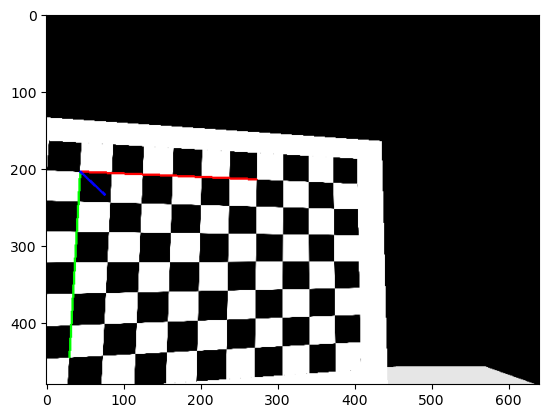

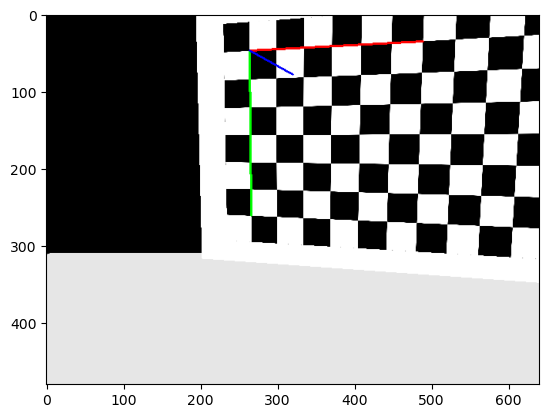

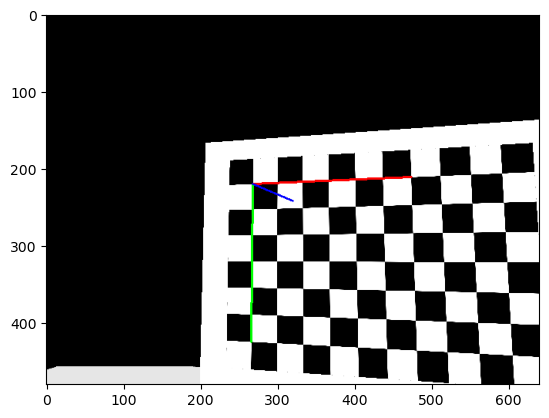

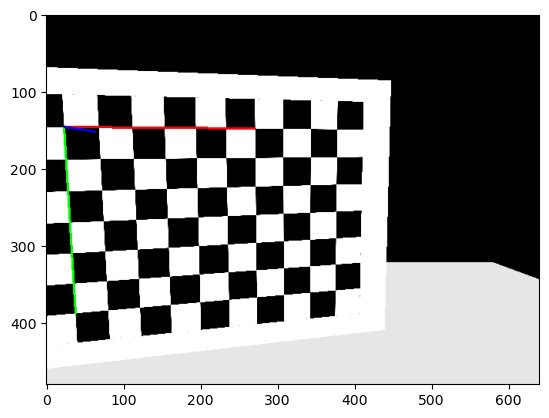

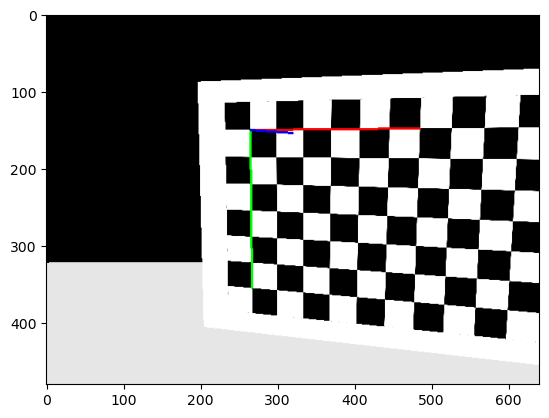

In [20]:
hand_eye_R_gripper2base = []
hand_eye_R_target2cam = []
hand_eye_t_gripper2base = []
hand_eye_t_target2cam = []

for img_pt, obj_pt, ee_pose, img in zip(image_points, obj_points, T_ee_poses, imgs):
    ret, rvec, tvec = cv2.solvePnP(obj_pt, img_pt, mtx, dist, flags=cv2.SOLVEPNP_EPNP)
    if ret:

        vis = cv2.drawFrameAxes(img.copy(), mtx, dist, rvec, tvec, 0.15, 2)
        plt.imshow(vis[...,::-1])
        plt.show()
        
        T_target2cam = np.eye(4, dtype=np.float32)
        T_target2cam[:3,:3] = cv2.Rodrigues(rvec)[0]
        T_target2cam[:3,-1] = tvec.ravel()
        T_target2cam = T_target2cam
        
        hand_eye_R_gripper2base.append(ee_pose[:3,:3])
        hand_eye_t_gripper2base.append(ee_pose[:3,-1])
        hand_eye_R_target2cam.append(T_target2cam[:3,:3])
        hand_eye_t_target2cam.append(T_target2cam[:3,-1])

In [21]:
R_tcp, t_tcp = cv2.calibrateHandEye(hand_eye_R_gripper2base, hand_eye_t_gripper2base, hand_eye_R_target2cam, hand_eye_t_target2cam)
T_tcp = np.eye(4, dtype=np.float32)
T_tcp[:3,:3] = R_tcp
T_tcp[:3,-1] = t_tcp.ravel()

In [22]:
T_tcp

array([[ 0.001, -1.   , -0.   ,  0.075],
       [ 1.   ,  0.001, -0.002, -0.014],
       [ 0.002, -0.   ,  1.   ,  0.058],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)

In [23]:
T_gl2cv = np.array([[-1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]], dtype=np.float32)

In [24]:
get_frame_pose(sim, ur_ee, camera_bgr) @ T_gl2cv

array([[-0.   , -1.   ,  0.   ,  0.075],
       [ 1.   , -0.   , -0.   , -0.014],
       [ 0.   ,  0.   ,  1.   ,  0.056],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)